## Plot seasonal maps of 2m air temperature anomalies

In [1]:
import cftime
import numpy as np
import xarray as xr
import pandas as pd
xr.set_options(keep_attrs=True)
import climpred
import intake
from tqdm import tqdm
import dask.array as da
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import xskillscore as xs
import warnings
warnings.filterwarnings("ignore")

from dask.distributed import Client
import dask.config
dask.config.set({"array.slicing.split_large_chunks": False})

- Make sure you have copied the correct tcp here from the `cluster.ipynb` notebook

In [2]:
client = Client("tcp://10.12.206.54:46614")

- Select models, lead, area, variables and metrics here.

In [3]:
variable = "t2m" #can be t2m, tp, gh_500
metric = "acc" #can be rps, rmse, acc
data = "anom" # can be anom, raw
lead = "biweekly" #biweekly or daily
area = "geospatial"
dim = "country"
start = "1999-01-01"
end = "2021-12-31" 
models = ["ECMWF","NCEP","CESM2"] #this notebook uses all three of these models

In [4]:
# Define region over CONUS
Regions= {"CONUS": [203,299,50,23] , "WC": [235,245, 50, 25 ] , "MW": [245, 255, 50, 25], "PL": [255,267, 50, 25], "NE" : [267,296, 50,37], "SE": [267,296, 37,25]}
region = "CONUS"

In [5]:
cat = intake.open_catalog('/glade/u/home/jaye/ASP_github/ASP_data_catalog.yml')

In [6]:
hinds = {}
for m in models:
    hinds[m] = cat[m](data=data, lead=lead, dim=area).to_dask().astype('float32')
verif = cat['OBS'](data=data, lead=lead, dim=area).to_dask().astype('float32')

In [7]:
obs_seas = verif.t2m.sel(lon = slice(Regions[region][0],Regions[region][1]), lat = slice(Regions[region][2],Regions[region][3])).groupby('time.season').mean(dim=['time'])
# obs_seas

In [8]:
# Group by and average over season, member
# Select lead time of 1
ecmwf_seas = hinds['ECMWF'].t2m.sel(lead='1 days',lon = slice(Regions[region][0],Regions[region][1]), lat = slice(Regions[region][2],Regions[region][3])).groupby('init.season').mean(dim=['init']).mean(dim=['member'])
# cesm2_seas

In [12]:
# Find difference betwn hinds and obs for all variables
diff= ecmwf_seas - obs_seas

In [13]:
xr_all = xr.concat([obs_seas, ecmwf_seas, diff], dim='results').assign_coords(results=['OBS', 'ECMWF', 'DIFF'])

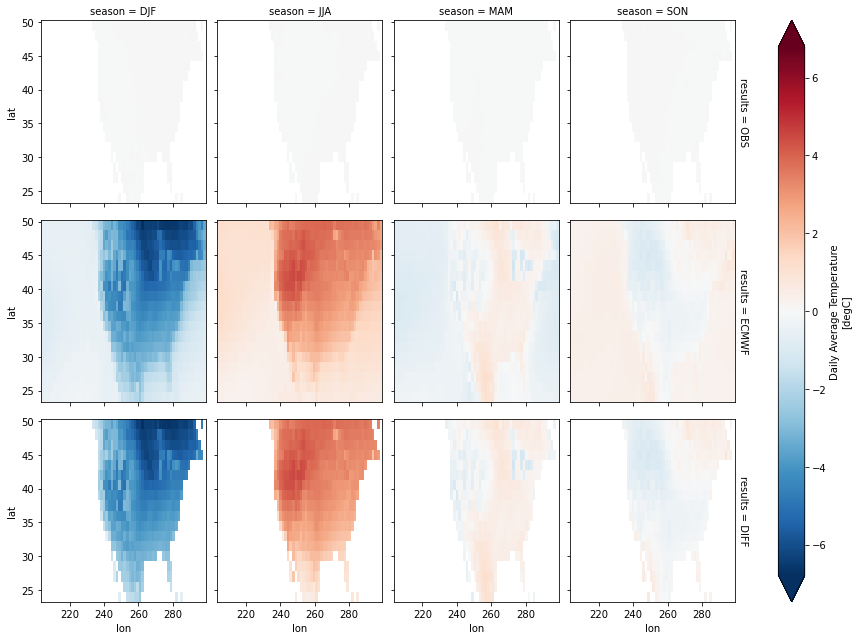

In [18]:
xr_all.plot(col='season', row='results', cmap='RdBu_r',robust=False, extend='both', add_colorbar=True)

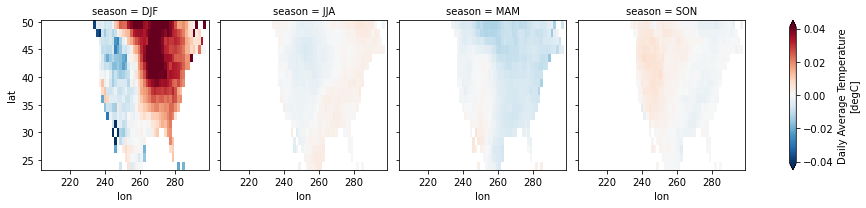

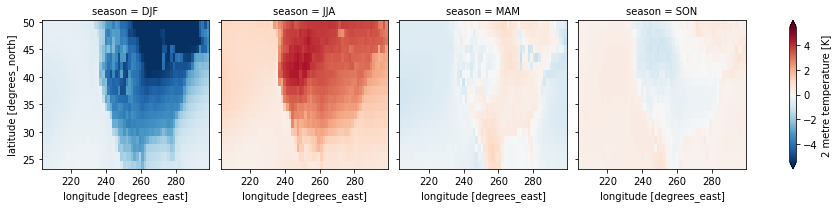

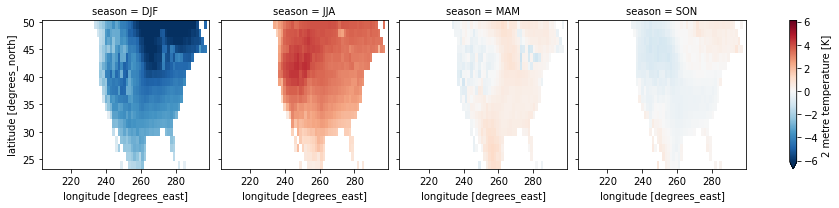

In [17]:
obs_seas.plot(col='season', cmap='RdBu_r', extend='both', robust=True)
ecmwf_seas.plot(col='season', cmap='RdBu_r', extend='both', robust=True)
diff.plot(col='season', cmap='RdBu_r',robust=True)